In [279]:
import folktables
from folktables import ACSDataSource
import numpy as np

np.random.seed(0)
#(Age) must be greater than 16 and less than 90, and (Person weight) must be greater than or equal to 1
def employment_filter(data):
    """
    Filters for the employment prediction task
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df
ACSEmployment = folktables.BasicProblem(
    features=[
       'AGEP', #age; for range of values of features please check Appendix B.4 of
           #Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
       'SCHL', #educational attainment
       'MAR', #marital status
       'RELP', #relationship
       'DIS', #disability recode
       'ESP', #employment status of parents
       'CIT', #citizenship status
       'MIG', #mobility status (lived here 1 year ago)
       'MIL', #military service
       'ANC', #ancestry recode
       'NATIVITY', #nativity
       'DEAR', #hearing difficulty
       'DEYE', #vision difficulty
       'DREM', #cognitive difficulty
       'SEX', #sex
       'RAC1P', #recoded detailed race code
       'GCL', #grandparents living with grandchildren
    ],
    target='ESR', #employment status recode
    target_transform=lambda x: x == 1,
    group='DIS',
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["FL"], download=True) #data for Florida state
features, label, group = ACSEmployment.df_to_numpy(acs_data)

In [280]:
from aif360.datasets import StandardDataset
import pandas as pd
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label
categorical_columns = ['MAR', 'RELP', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'GCL']

# apply one-hot encoding
encoded_data = pd.get_dummies(data, columns=categorical_columns)
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
data_for_aif = StandardDataset(encoded_data, 'label', favorable_classes = favorable_classes,
                      protected_attribute_names = protected_attribute_names,
                      privileged_classes = privileged_classes)
privileged_groups = [{'DIS': 1}]
unprivileged_groups = [{'DIS': 2}]

/Users/Kotsi/Desktop/AI_Imperial/Ethics/Fairness-ML/my_env/lib/python3.11/site-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label


### Task 1(a) - Split data

In [281]:
data_size = data_for_aif.features.shape[0]
train, test = data_for_aif.split([0.7], shuffle=True)
splits = []
for _ in range(5):
    train, val = train.split([0.8], shuffle=True)
    splits.append((train, val))

In [282]:
train.features.shape

(38374, 73)

### Task 1(b) - Model selection

In [283]:
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression


def find_most_accurate_logistic_reg_model(splits, parameters, reweighing=False):
    mean_accuracies = []
    final_scaler = None
    max_accuracy = -float('inf')
    best_model = None
    for parameter in parameters:
        accuracies = []
        for train, val in splits:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train.features)
            y_train = train.labels.ravel()

            X_val = scaler.transform(val.features)
            y_val = val.labels.ravel()
            learner = LogisticRegression(C=parameter, solver='liblinear', random_state=1)
            if reweighing:
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

                train = RW.fit_transform(train)
                learner.fit(X_train, y_train, sample_weight=train.instance_weights)
            else:
                learner.fit(X_train, y_train)   
            predictions = learner.predict(X_val)
            accuracy = sum((predictions==y_val) / len(y_val))
            accuracies.append(accuracy)
        mean_accuracy = sum(accuracies) / len(accuracies)
        #print(mean_accuracy)
        mean_accuracies.append(mean_accuracy)
        if mean_accuracy > max_accuracy:
            max_accuracy = mean_accuracy
            best_model = learner
            final_scaler = scaler
    return best_model, final_scaler, max_accuracy, parameters, mean_accuracies



In [284]:
parameters = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
final_model, final_scaler, final_accuracy, parameters, mean_accuracies = find_most_accurate_logistic_reg_model(splits=splits, parameters=parameters)
for i,j in zip(parameters, mean_accuracies):
    print(f"C={i}      Accuracy={j}")

C=1e-09      Accuracy=0.7238689747148399
C=1e-08      Accuracy=0.7238860519466208
C=1e-07      Accuracy=0.7241011483727242
C=1e-06      Accuracy=0.7255109331702649
C=1e-05      Accuracy=0.7356144679802412
C=0.0001      Accuracy=0.7585211005920811
C=0.001      Accuracy=0.7774071247641452
C=0.01      Accuracy=0.7788029375892355
C=0.1      Accuracy=0.7786850955544086
C=1      Accuracy=0.7787922585092171
C=10      Accuracy=0.7787922585092171
C=100      Accuracy=0.7787922585092171


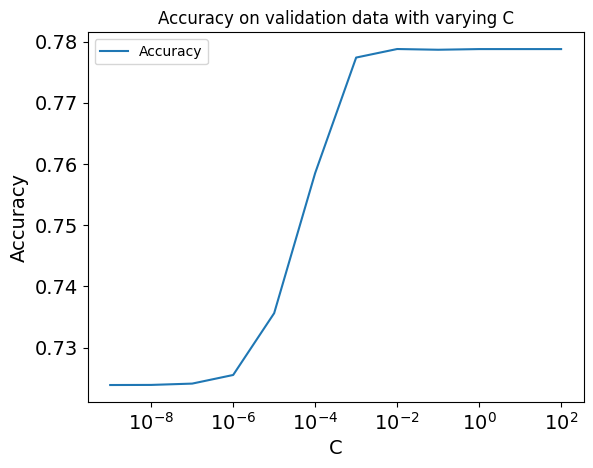

In [285]:
import matplotlib.pyplot as plt
plt.rc('axes', titlesize='large')    # Default is typically 'large'
plt.rc('axes', labelsize='medium')   # Default is 'medium'
plt.rc('xtick', labelsize='medium')  # Default is 'medium'
plt.rc('ytick', labelsize='medium')  # Default is 'medium'
plt.rc('legend', fontsize='medium')  # Default is 'medium'


plt.plot(parameters, mean_accuracies, label='Accuracy') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Accuracy on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Accuracy', fontsize=14)     

plt.legend()
#plt.savefig("non-pre_accuracy.png", dpi=600)
plt.show()

In [286]:
print(f"Final Model: {final_model}\n")
print(f"Final Scaler: {final_scaler}\n")
print(f"Final Mean Accuracy on Val data : {final_accuracy}")

Final Model: LogisticRegression(C=0.01, random_state=1, solver='liblinear')

Final Scaler: StandardScaler()

Final Mean Accuracy on Val data : 0.7788029375892355


### Test the final model on test data

In [287]:
from aif360.metrics import ClassificationMetric

def test_model_on_unseen_data(final_scaler, test, final_model, unprivileged_groups, privileged_groups):
    X_test = final_scaler.transform(test.features)
    y_test = test.labels.ravel()

    test_predictions = final_model.predict(X_test)

    test_pred = test.copy()
    test_pred.labels = test_predictions

    test_accuracy = sum((test_predictions == y_test) / len(y_test))

    metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    eq_opp_diff = metric.equal_opportunity_difference()

    return test_accuracy, eq_opp_diff

In [288]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data

In [289]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7774147274469237

Fairness on test data using the equal opportunity difference metric: 0.5857518030498707


### Task(c) - Model selection based on fairness

In [290]:
def find_most_fair_logistic_reg_model(splits, parameters, reweighing=False):
    mean_fearnesses = []
    mean_fairnesses_abs = []
    final_scaler = None
    min_diff = float('inf')
    best_model = None
    for parameter in parameters:
        fairnesses = []
        fairnesses_abs = []
        for train, val in splits:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train.features)
            y_train = train.labels.ravel()

            X_val = scaler.transform(val.features)
            y_val = val.labels.ravel()
            learner = LogisticRegression(C=parameter, solver='liblinear', random_state=1)
            if reweighing:
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

                train = RW.fit_transform(train)
                learner.fit(X_train, y_train, sample_weight=train.instance_weights)
            else:
                learner.fit(X_train, y_train)  
            predictions = learner.predict(X_val)
            
            val_pred = val.copy()
            val_pred.labels = predictions
            metric = ClassificationMetric(val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
            fairness = metric.equal_opportunity_difference()
            fairnesses.append(fairness)
            fairness_abs = abs(metric.equal_opportunity_difference())
            fairnesses_abs.append(fairness_abs)
        mean_fairness = sum(fairnesses) / len(fairnesses)
        mean_fearnesses.append(mean_fairness)
        mean_fairness_abs = sum(fairnesses_abs) / len(fairnesses_abs)
        mean_fairnesses_abs.append(mean_fairness_abs)
        #print(mean_fairness)
        if mean_fairness_abs < min_diff:
            min_diff = mean_fairness_abs
            best_model = learner
            final_scaler = scaler
    return best_model, final_scaler, min_diff, parameters, mean_fairnesses_abs, mean_fearnesses

In [291]:
final_model, final_scaler, final_fairness, parameters, mean_fairnesses_abs, mean_fairnesses = find_most_fair_logistic_reg_model(splits = splits, parameters=parameters)

for parameter, fairness in zip(parameters, mean_fairnesses):
    print(f"C={parameter}    Fairness={fairness}")

C=1e-09    Fairness=0.8492475365910886
C=1e-08    Fairness=0.8493351732664711
C=1e-07    Fairness=0.849459957146166
C=1e-06    Fairness=0.8493510562945262
C=1e-05    Fairness=0.8495294759487493
C=0.0001    Fairness=0.7773896498355815
C=0.001    Fairness=0.6343125086130825
C=0.01    Fairness=0.576977870105907
C=0.1    Fairness=0.5697002045514639
C=1    Fairness=0.5675217401631857
C=10    Fairness=0.5675217401631857
C=100    Fairness=0.5675217401631857


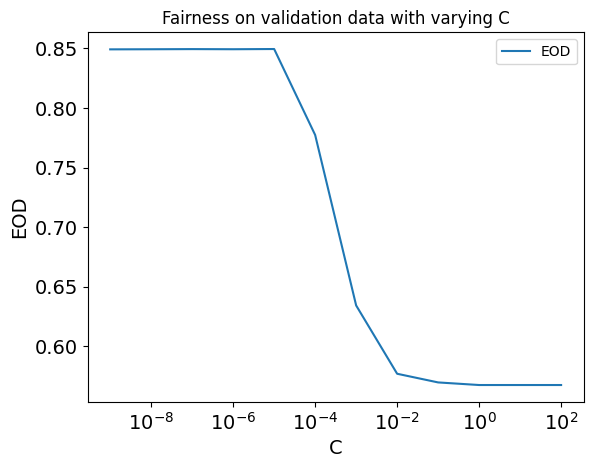

In [292]:
import matplotlib.pyplot as plt

plt.plot(parameters, mean_fairnesses_abs, label='EOD') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Fairness on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('EOD', fontsize=14)     

plt.legend()
#plt.savefig("non-pre_fairness.png", dpi=600)
plt.show()

### Test the final model on test data

In [293]:
final_model

LogisticRegression(C=1, random_state=1, solver='liblinear')

In [294]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data

In [295]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7774744979282754

Fairness on test data using the equal opportunity difference metric: 0.5740695180998419


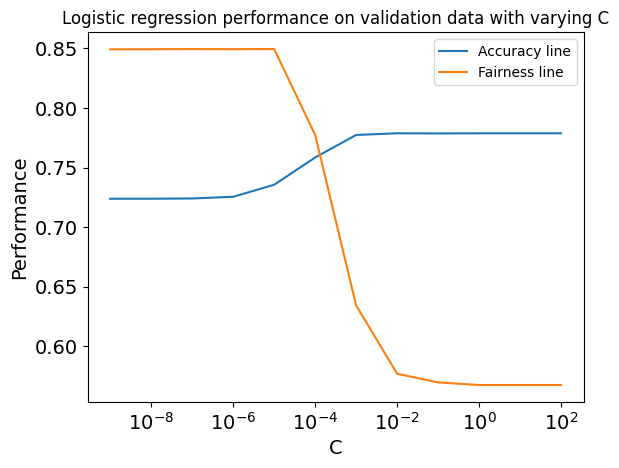

In [296]:
import matplotlib.pyplot as plt

plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.plot(parameters, mean_fairnesses, label='Fairness line')
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression performance on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Performance',fontsize=14)     

plt.legend()
#plt.savefig("non-pre_performance.png", dpi=600)
plt.show()

### Task 2(a) - Select the most accurate model after reweighing

In [297]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

final_model, final_scaler, final_accuracy, parameters, mean_accuracies = find_most_accurate_logistic_reg_model(splits=splits, parameters=parameters, reweighing=True)

for parameter, accuracy in zip(parameters, mean_accuracies):
    print(f"C={parameter}     Accuracy={accuracy}")

C=1e-09     Accuracy=0.7132729971277939
C=1e-08     Accuracy=0.7132943429840296
C=1e-07     Accuracy=0.7134236234239874
C=1e-06     Accuracy=0.7146602386802776
C=1e-05     Accuracy=0.7220114814265781
C=0.0001     Accuracy=0.7376080806311762
C=0.001     Accuracy=0.7469605948170075
C=0.01     Accuracy=0.7452749223652585
C=0.1     Accuracy=0.7446863671628047
C=1     Accuracy=0.74459697824712
C=10     Accuracy=0.7446034812074915
C=100     Accuracy=0.7446034812074915


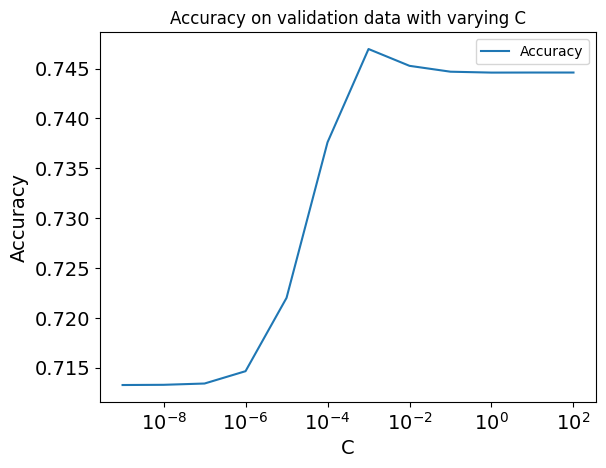

In [298]:
plt.plot(parameters, mean_accuracies, label='Accuracy') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Accuracy on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Accuracy', fontsize=14)     

plt.legend()
#plt.savefig("pre_accuracy.png", dpi=600)
plt.show()

In [299]:
final_model

LogisticRegression(C=0.001, random_state=1, solver='liblinear')

### Test the most accurate model after reweighting on the test data

In [300]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data after reweighing

In [301]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7440428753589249

Fairness on test data using the equal opportunity difference metric: 0.018113492409268295


### Task 2(b) - Select the most fair model after reweighing

In [302]:
final_model, final_scaler, final_fairness, parameters, mean_fairnesses_abs, mean_fairnesses= find_most_fair_logistic_reg_model(splits=splits, parameters=parameters, reweighing=True)

for parameter, fairness in zip(parameters, mean_fairnesses):
    print(f"C={parameter}    Fairness={fairness}")

C=1e-09    Fairness=0.1543351925137281
C=1e-08    Fairness=0.15398369866487044
C=1e-07    Fairness=0.1531217101391264
C=1e-06    Fairness=0.14511312513404379
C=1e-05    Fairness=0.09834461629072691
C=0.0001    Fairness=0.02564848510399107
C=0.001    Fairness=-0.015279235331008811
C=0.01    Fairness=-0.024329428729210754
C=0.1    Fairness=-0.02755819885734876
C=1    Fairness=-0.02779997723571681
C=10    Fairness=-0.0277662901883865
C=100    Fairness=-0.0277662901883865


In [303]:
final_model

LogisticRegression(C=0.001, random_state=1, solver='liblinear')

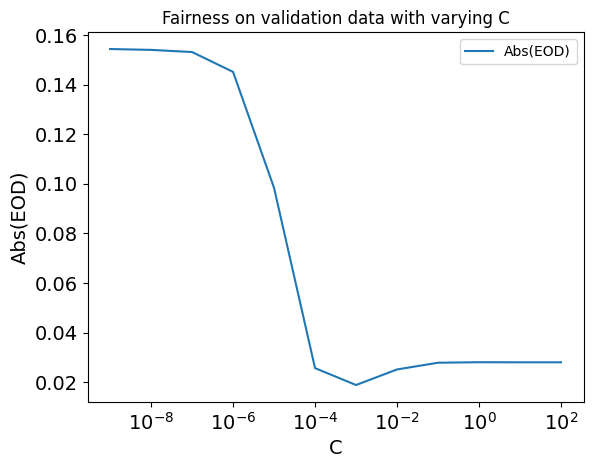

In [304]:
plt.plot(parameters, mean_fairnesses_abs, label='Abs(EOD)') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Fairness on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Abs(EOD)', fontsize=14)     


plt.legend()
#plt.savefig("pre_fairness.png", dpi=600)
plt.show()

### Test the most fair model after reweighting on the test data

In [305]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data after reweighing

In [306]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7440428753589249

Fairness on test data using the equal opportunity difference metric: 0.018113492409268295


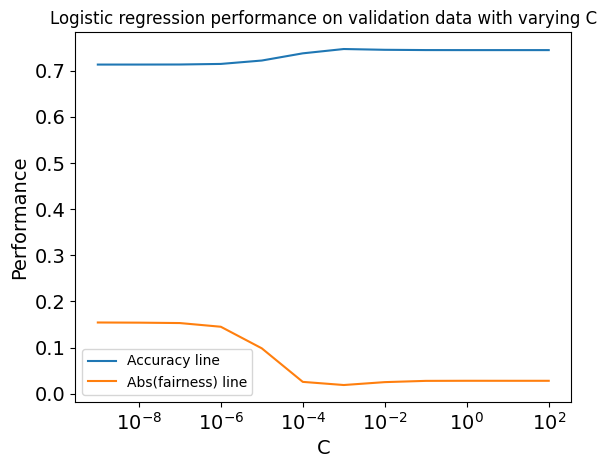

In [307]:
plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.plot(parameters, mean_fairnesses_abs, label='Abs(fairness) line')
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression performance on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Performance', fontsize=14)     

plt.legend()
plt.savefig("pre_performance.png", dpi=600)
plt.show()

### Task 3(a) Find best standard model

In [308]:
def find_best_model(splits, parameters, reweighing=False, weight_0=0.75, weight_1=0.25):
    mean_combined_metrics = []
    final_scaler = None
    max_ = -float('inf')
    best_model = None
    for parameter in parameters:
        combined_metrics = []
        for train, val in splits:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train.features)
            y_train = train.labels.ravel()

            X_val = scaler.transform(val.features)
            y_val = val.labels.ravel()
            learner = LogisticRegression(C=parameter, solver='liblinear', random_state=1)
            if reweighing:
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

                train = RW.fit_transform(train)
                learner.fit(X_train, y_train, sample_weight=train.instance_weights)
            else:
                learner.fit(X_train, y_train)  
            predictions = learner.predict(X_val)
            

            accuracy = sum((predictions == y_val) / len(y_val) )
            
            val_pred = val.copy()
            val_pred.labels = predictions
            metric = ClassificationMetric(val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
            fairness_abs = abs(metric.equal_opportunity_difference())
            combined_metric = weight_0 * min(1 - fairness_abs, accuracy) + weight_1 * max(accuracy, (1 - fairness_abs))
            combined_metrics.append(combined_metric)
        mean_combined_metric = sum(combined_metrics) / len(combined_metrics)
        mean_combined_metrics.append(mean_combined_metric)
        #print(mean_fairness)
        if mean_combined_metric > max_:
            max_ = mean_combined_metric
            best_model = learner
            final_scaler = scaler
    return best_model, final_scaler, max_, parameters, mean_combined_metrics

In [309]:
final_model, final_scaler, max_, parameters, mean_combined_metrics = find_best_model(splits=splits, parameters=parameters)
for parameter, combined_metric in zip(parameters, mean_combined_metrics):
    print(f"C={parameter}    Combined metric={combined_metric}")

C=1e-09    Combined metric=0.2940315912353936
C=1e-08    Combined metric=0.29397013303680175
C=1e-07    Combined metric=0.2939303192335566
C=1e-06    Combined metric=0.2943644410716716
C=1e-05    Combined metric=0.29675651003349834
C=0.0001    Combined metric=0.3565880377713341
C=0.001    Combined metric=0.46861739973122435
C=0.01    Combined metric=0.5119673318178786
C=0.1    Combined metric=0.5173961204750042
C=1    Combined metric=0.519056759504915
C=10    Combined metric=0.519056759504915
C=100    Combined metric=0.519056759504915


In [310]:
final_model, max_

(LogisticRegression(C=1, random_state=1, solver='liblinear'),
 0.519056759504915)

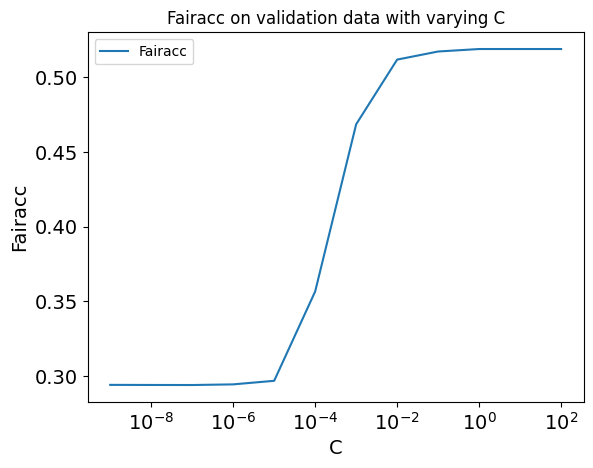

In [311]:
plt.plot(parameters, mean_combined_metrics, label='Fairacc') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Fairacc on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Fairacc', fontsize=14)     

plt.legend()



plt.show()

In [312]:
def test_model_on_unseen_data_weighted(final_scaler, test, final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, weight_0=0.75, weight_1=0.25):
    X_test = final_scaler.transform(test.features)
    y_test = test.labels.ravel()

    test_predictions = final_model.predict(X_test)

    test_pred = test.copy()
    test_pred.labels = test_predictions

    test_accuracy = sum((test_predictions == y_test) / len(y_test))

    metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    eq_opp_diff = abs(metric.equal_opportunity_difference())
    
    combined_metric = weight_0 * min(test_accuracy, 1-eq_opp_diff) + weight_1 * max(1-eq_opp_diff, test_accuracy)

    return combined_metric


In [313]:
test_combined_metric = test_model_on_unseen_data_weighted(final_scaler=final_scaler, test=test, final_model=final_model)

In [314]:
print(f"Final combined metric of best model on unseen data: {test_combined_metric}")

Final combined metric of best model on unseen data: 0.5138164859071874


### Task 3(b)

In [315]:
final_model, final_scaler, max_, parameters, mean_combined_metrics = find_best_model(splits=splits, parameters=parameters, reweighing=True)

for parameter, combined_metric in zip(parameters, mean_combined_metrics):
    print(f"C={parameter}    Combined Metric={combined_metric}")

C=1e-09    Combined Metric=0.7463709497174135
C=1e-08    Combined Metric=0.7464748325718047
C=1e-07    Combined Metric=0.7467872900332089
C=1e-06    Combined Metric=0.7497168977266974
C=1e-05    Combined Metric=0.7669224569972519
C=0.0001    Combined Metric=0.7967939391973843
C=0.001    Combined Metric=0.8055128415999242
C=0.01    Combined Metric=0.8026791397019636
C=0.1    Combined Metric=0.8015598857180717
C=1    Combined Metric=0.8014410231000481
C=10    Combined Metric=0.8014543220821594
C=100    Combined Metric=0.8014543220821594


In [316]:
final_model, max_

(LogisticRegression(C=0.001, random_state=1, solver='liblinear'),
 0.8055128415999242)

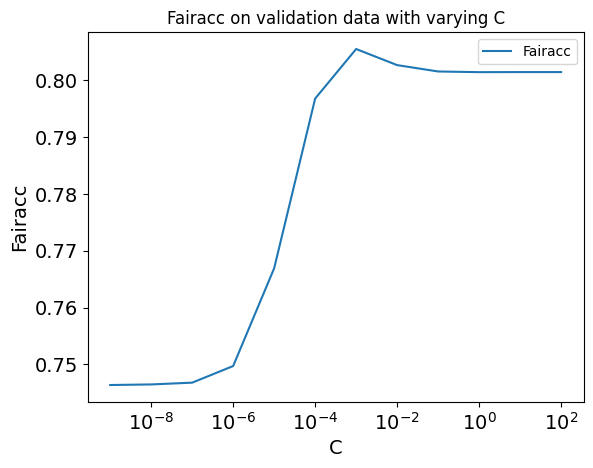

In [317]:
plt.plot(parameters, mean_combined_metrics, label='Fairacc') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Fairacc on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Fairacc', fontsize=14)     

plt.legend()
#plt.savefig("_pre_performance_.png", dpi=600)
plt.show()

In [318]:
test_combined_metric = test_model_on_unseen_data_weighted(final_scaler=final_scaler, test=test, final_model=final_model)

In [319]:
print(f"Final combined metric of best model on unseen data: {test_combined_metric}")

Final combined metric of best model on unseen data: 0.8035037834168766


## Extra Section : Perform model selection on data for Florida state (states=[”FL”]), while test on data for Texas (states=[”TX”]). Analyse how this change the performance of the models 1-6.

### Split the Florida state data into 5 random splits 0.7/0.3 

In [320]:
acs_data = data_source.get_data(states=["TX"], download=True) #data for Texas state
features, label, group = ACSEmployment.df_to_numpy(acs_data)

In [321]:
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label
categorical_columns = ['MAR', 'RELP', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'GCL']

# apply one-hot encoding
encoded_data = pd.get_dummies(data, columns=categorical_columns)
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
data_for_aif = StandardDataset(encoded_data, 'label', favorable_classes = favorable_classes,
                      protected_attribute_names = protected_attribute_names,
                      privileged_classes = privileged_classes)
privileged_groups = [{'DIS': 1}]
unprivileged_groups = [{'DIS': 2}]


/Users/Kotsi/Desktop/AI_Imperial/Ethics/Fairness-ML/my_env/lib/python3.11/site-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label


In [322]:
test = data_for_aif
test.features.shape

(208358, 73)

### Model 1

In [323]:
final_model, final_scaler, final_accuracy, parameters, mean_accuracies = find_most_accurate_logistic_reg_model(splits=splits, parameters=parameters)
for i,j in zip(parameters, mean_accuracies):
    print(f"C={i}      Accuracy={j}")

C=1e-09      Accuracy=0.7238689747148399
C=1e-08      Accuracy=0.7238860519466208
C=1e-07      Accuracy=0.7241011483727242
C=1e-06      Accuracy=0.7255109331702649
C=1e-05      Accuracy=0.7356144679802412
C=0.0001      Accuracy=0.7585211005920811
C=0.001      Accuracy=0.7774071247641452
C=0.01      Accuracy=0.7788029375892355
C=0.1      Accuracy=0.7786850955544086
C=1      Accuracy=0.7787922585092171
C=10      Accuracy=0.7787922585092171
C=100      Accuracy=0.7787922585092171


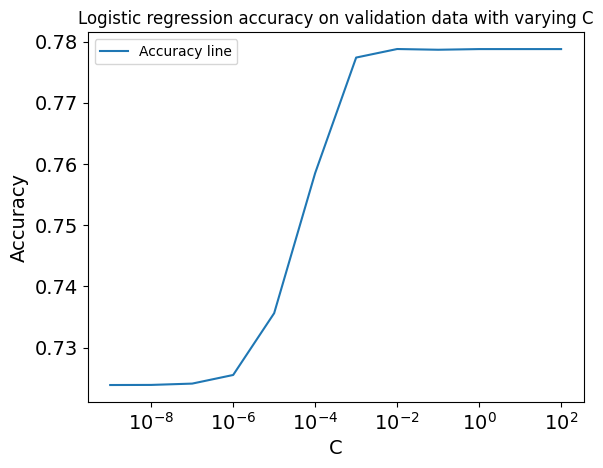

In [324]:
import matplotlib.pyplot as plt
plt.rc('axes', titlesize='large')    # Default is typically 'large'
plt.rc('axes', labelsize='medium')   # Default is 'medium'
plt.rc('xtick', labelsize='medium')  # Default is 'medium'
plt.rc('ytick', labelsize='medium')  # Default is 'medium'
plt.rc('legend', fontsize='medium')  # Default is 'medium'


plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression accuracy on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Accuracy', fontsize=14)     

plt.legend()
#plt.savefig("non-pre_accuracy.png", dpi=600)
plt.show()

In [325]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

In [326]:
final_model

LogisticRegression(C=0.01, random_state=1, solver='liblinear')

In [327]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7587949586761981

Fairness on test data using the equal opportunity difference metric: 0.5660078536700246


### Model 2

In [328]:
final_model, final_scaler, final_fairness, parameters, mean_fairnesses_abs, mean_fairnesses = find_most_fair_logistic_reg_model(splits = splits, parameters=parameters)

for parameter, fairness in zip(parameters, mean_fairnesses):
    print(f"C={parameter}    Fairness={fairness}")

C=1e-09    Fairness=0.8492475365910886
C=1e-08    Fairness=0.8493351732664711
C=1e-07    Fairness=0.849459957146166
C=1e-06    Fairness=0.8493510562945262
C=1e-05    Fairness=0.8495294759487493
C=0.0001    Fairness=0.7773896498355815
C=0.001    Fairness=0.6343125086130825
C=0.01    Fairness=0.576977870105907
C=0.1    Fairness=0.5697002045514639
C=1    Fairness=0.5675217401631857
C=10    Fairness=0.5675217401631857
C=100    Fairness=0.5675217401631857


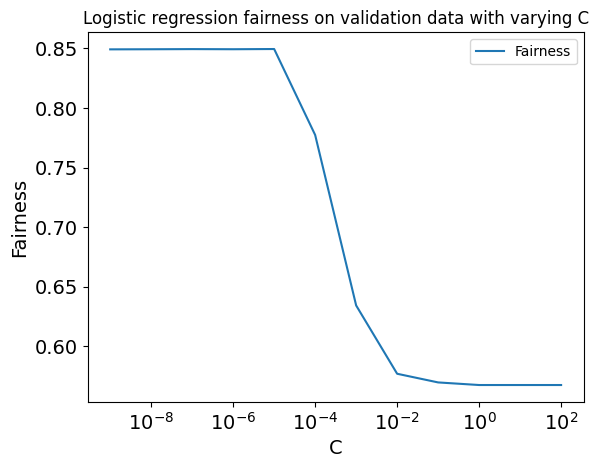

In [329]:
import matplotlib.pyplot as plt

plt.plot(parameters, mean_fairnesses_abs, label='Fairness') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression fairness on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Fairness', fontsize=14)     

plt.legend()
#plt.savefig("non-pre_fairness.png", dpi=600)
plt.show()

In [330]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

In [331]:
final_model

LogisticRegression(C=1, random_state=1, solver='liblinear')

In [332]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7583438120919567

Fairness on test data using the equal opportunity difference metric: 0.5536590603079564


### Model 3

In [333]:
final_model, final_scaler, final_accuracy, parameters, mean_accuracies = find_most_accurate_logistic_reg_model(splits=splits, parameters=parameters, reweighing=True)

for parameter, accuracy in zip(parameters, mean_accuracies):
    print(f"C={parameter}     Accuracy={accuracy}")

C=1e-09     Accuracy=0.7132729971277939
C=1e-08     Accuracy=0.7132943429840296
C=1e-07     Accuracy=0.7134236234239874
C=1e-06     Accuracy=0.7146602386802776
C=1e-05     Accuracy=0.7220114814265781
C=0.0001     Accuracy=0.7376080806311762
C=0.001     Accuracy=0.7469605948170075
C=0.01     Accuracy=0.7452749223652585
C=0.1     Accuracy=0.7446863671628047
C=1     Accuracy=0.74459697824712
C=10     Accuracy=0.7446034812074915
C=100     Accuracy=0.7446034812074915


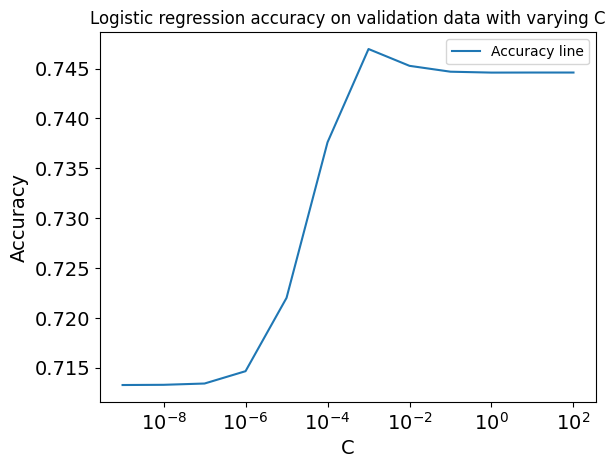

In [334]:
plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression accuracy on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Accuracy', fontsize=14)     

plt.legend()
plt.savefig("pre_accuracy.png", dpi=600)
plt.show()

In [335]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

In [336]:
final_model

LogisticRegression(C=0.001, random_state=1, solver='liblinear')

In [337]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7294272358147824

Fairness on test data using the equal opportunity difference metric: 0.029236040544831643


### Model 4

In [338]:
final_model, final_scaler, final_fairness, parameters, mean_fairnesses_abs, mean_fairnesses= find_most_fair_logistic_reg_model(splits=splits, parameters=parameters, reweighing=True)

for parameter, fairness in zip(parameters, mean_fairnesses):
    print(f"C={parameter}    Fairness={fairness}")

C=1e-09    Fairness=0.1543351925137281
C=1e-08    Fairness=0.15398369866487044
C=1e-07    Fairness=0.1531217101391264
C=1e-06    Fairness=0.14511312513404379
C=1e-05    Fairness=0.09834461629072691
C=0.0001    Fairness=0.02564848510399107
C=0.001    Fairness=-0.015279235331008811
C=0.01    Fairness=-0.024329428729210754
C=0.1    Fairness=-0.02755819885734876
C=1    Fairness=-0.02779997723571681
C=10    Fairness=-0.0277662901883865
C=100    Fairness=-0.0277662901883865


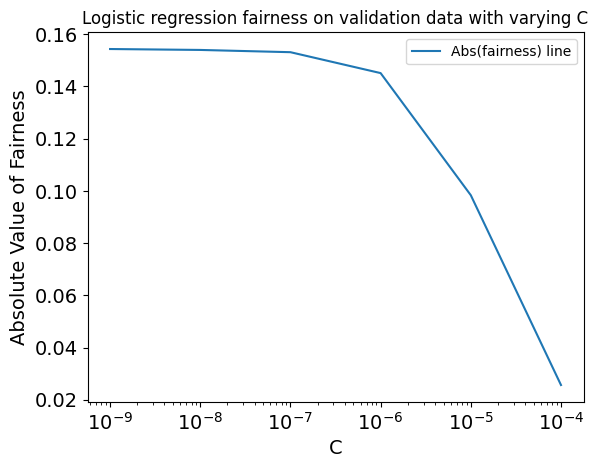

In [339]:
plt.plot(parameters[:6], mean_fairnesses_abs[:6], label='Abs(fairness) line') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression fairness on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Absolute Value of Fairness', fontsize=14)     

plt.legend()
plt.savefig("pre_fairness.png", dpi=600)
plt.show()

In [340]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

In [341]:
final_model

LogisticRegression(C=0.001, random_state=1, solver='liblinear')

In [342]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7294272358147824

Fairness on test data using the equal opportunity difference metric: 0.029236040544831643


### Model 5

In [343]:
final_model, final_scaler, max_, parameters, mean_combined_metrics = find_best_model(splits=splits, parameters=parameters)
for parameter, combined_metric in zip(parameters, mean_combined_metrics):
    print(f"C={parameter}    Combined metric={combined_metric}")

C=1e-09    Combined metric=0.2940315912353936
C=1e-08    Combined metric=0.29397013303680175
C=1e-07    Combined metric=0.2939303192335566
C=1e-06    Combined metric=0.2943644410716716
C=1e-05    Combined metric=0.29675651003349834
C=0.0001    Combined metric=0.3565880377713341
C=0.001    Combined metric=0.46861739973122435
C=0.01    Combined metric=0.5119673318178786
C=0.1    Combined metric=0.5173961204750042
C=1    Combined metric=0.519056759504915
C=10    Combined metric=0.519056759504915
C=100    Combined metric=0.519056759504915


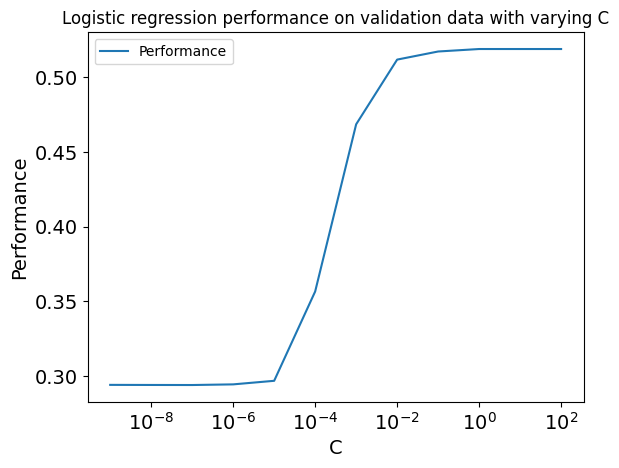

In [344]:
plt.plot(parameters, mean_combined_metrics, label='Performance') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression performance on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Performance', fontsize=14)     


plt.legend()



plt.show()

In [345]:
test_combined_metric = test_model_on_unseen_data_weighted(final_scaler=final_scaler, test=test, final_model=final_model)

In [346]:
final_model

LogisticRegression(C=1, random_state=1, solver='liblinear')

In [347]:
print(f"Final combined metric of best model on unseen data: {test_combined_metric}")

Final combined metric of best model on unseen data: 0.5243416577920219


In [348]:
final_model, final_scaler, max_, parameters, mean_combined_metrics= find_best_model(splits=splits, parameters=parameters, reweighing=True)

for parameter, combined_metric in zip(parameters, mean_combined_metrics):
    print(f"C={parameter}    Combined Metric={combined_metric}")

C=1e-09    Combined Metric=0.7463709497174135
C=1e-08    Combined Metric=0.7464748325718047
C=1e-07    Combined Metric=0.7467872900332089
C=1e-06    Combined Metric=0.7497168977266974
C=1e-05    Combined Metric=0.7669224569972519
C=0.0001    Combined Metric=0.7967939391973843
C=0.001    Combined Metric=0.8055128415999242
C=0.01    Combined Metric=0.8026791397019636
C=0.1    Combined Metric=0.8015598857180717
C=1    Combined Metric=0.8014410231000481
C=10    Combined Metric=0.8014543220821594
C=100    Combined Metric=0.8014543220821594


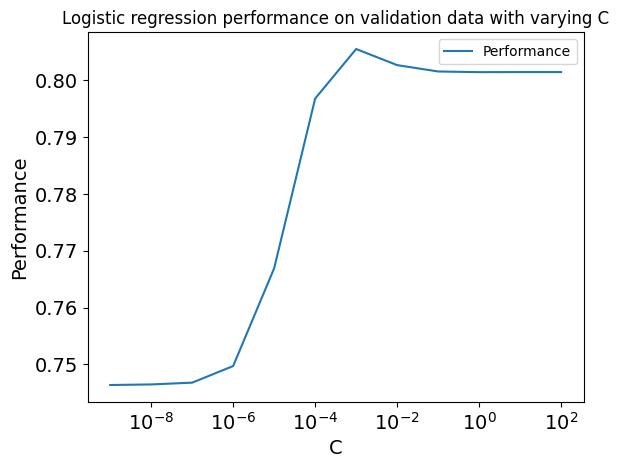

In [349]:
plt.plot(parameters, mean_combined_metrics, label='Performance') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression performance on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Performance', fontsize=14)     

plt.legend()
#plt.savefig("_pre_performance_.png", dpi=600)
plt.show()

In [350]:
test_combined_metric = test_model_on_unseen_data_weighted(final_scaler=final_scaler, test=test, final_model=final_model)

In [351]:
final_model

LogisticRegression(C=0.001, random_state=1, solver='liblinear')

In [352]:
print(f"Final combined metric of best model on unseen data: {test_combined_metric}")

Final combined metric of best model on unseen data: 0.789761416724879
